In [22]:
import os
import json
import librosa
import numpy as np
import pandas as pd

# Paths to JSON and audio files
json_folder = 'JSON'
audio_folder = 'wav_files'

# Match audio and JSON files
json_files = {os.path.splitext(f)[0]: os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')}
audio_files = {os.path.splitext(f)[0]: os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(('.wav', '.m4a', '.mp3'))}

matched_files = {name: (json_files[name], audio_files[name]) for name in json_files if name in audio_files}

print(matched_files)

{'cricket toppic': ('JSON/cricket toppic.json', 'wav_files/cricket toppic.wav'), 'R1': ('JSON/R1.json', 'wav_files/R1.wav'), 'New Recording 6': ('JSON/New Recording 6.json', 'wav_files/New Recording 6.wav'), 'Mirpur Road': ('JSON/Mirpur Road.json', 'wav_files/Mirpur Road.wav'), 'Recording_1': ('JSON/Recording_1.json', 'wav_files/Recording_1.wav'), 'Oct 7, 9.34 AM': ('JSON/Oct 7, 9.34 AM.json', 'wav_files/Oct 7, 9.34 AM.wav'), 'keralas calture': ('JSON/keralas calture.json', 'wav_files/keralas calture.wav'), 'the scientist': ('JSON/the scientist.json', 'wav_files/the scientist.wav'), 'Recording_2': ('JSON/Recording_2.json', 'wav_files/Recording_2.wav'), 'R5': ('JSON/R5.json', 'wav_files/R5.wav'), 'Sep 23, 9.24 AM': ('JSON/Sep 23, 9.24 AM.json', 'wav_files/Sep 23, 9.24 AM.wav'), 'English 1st conversation': ('JSON/English 1st conversation.json', 'wav_files/English 1st conversation.wav'), 'SS practice': ('JSON/SS practice.json', 'wav_files/SS practice.wav'), 'sanjid meyad': ('JSON/sanjid m

In [23]:
print(len(matched_files))

18


In [24]:
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = []
    for item in data[0]['annotations'][0]['result']:
        if item['type'] == 'labels':
            start = item['value']['start']
            end = item['value']['end']
            label = item['value']['labels'][0]
            annotations.append((start, end, label))
    return annotations

def extract_audio_segments(audio_file, annotations, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    segments = []
    for start, end, label in annotations:
        segment = y[int(start * sr):int(end * sr)]
        segments.append((segment, label))
    return segments

dataset = []
files_loaded = []

for name, (json_path, audio_path) in matched_files.items():
    if len(load_annotations(json_path)) != 0:
        files_loaded.append(json_path)
        annotations = load_annotations(json_path)
        audio_segments = extract_audio_segments(audio_path, annotations)
        dataset.extend(audio_segments)

In [25]:
print(files_loaded)

['JSON/cricket toppic.json', 'JSON/R1.json', 'JSON/New Recording 6.json', 'JSON/Mirpur Road.json', 'JSON/Recording_1.json', 'JSON/Oct 7, 9.34 AM.json', 'JSON/keralas calture.json', 'JSON/the scientist.json', 'JSON/Recording_2.json', 'JSON/R5.json', 'JSON/Sep 23, 9.24 AM.json', 'JSON/English 1st conversation.json', 'JSON/SS practice.json', 'JSON/sanjid meyad.json', 'JSON/Sep 25, 1.56 sa.json', 'JSON/Oct 20, 12.28 PM.json', 'JSON/Oct 6, 9.10 AM.json', 'JSON/R2.json']


In [26]:
def extract_features(segments, n_mfcc=40, max_length=300):
    features, labels = [], []
    for i, (segment, label) in enumerate(segments):
        try:
            # Dynamically adjust n_fft based on signal length
            n_fft = min(2048, len(segment))  # Use the smaller of 2048 or segment length

            # Extract MFCC features with adjusted n_fft
            mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=n_mfcc, n_fft=n_fft)

            # Handle variable lengths (pad if short, truncate if long)
            if mfcc.shape[1] < max_length:
                padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
            else:
                padded_mfcc = mfcc[:, :max_length]

            # Append features and labels
            features.append(padded_mfcc.T)
            labels.append(0 if label == 'Field pause' else 1)

        except Exception as e:
            print(f"Error processing segment {i}: {e}")

    return np.array(features), np.array(labels)

X, y = extract_features(dataset)

Before balancing - Class 0: 23, Class 1: 1400
After balancing - Class 0: 1400, Class 1: 1400


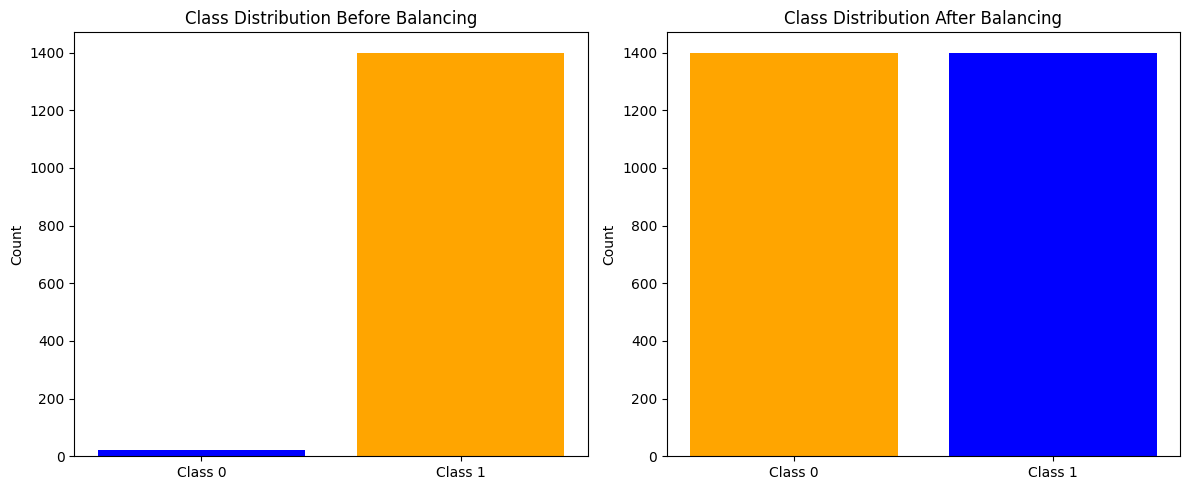

In [27]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
from collections import Counter

# Function to balance the dataset
def balance_dataset(features, labels):
    # Combine features and labels
    data = list(zip(features, labels))
    
    # Split into majority and minority classes
    class_0 = [d for d in data if d[1] == 0]
    class_1 = [d for d in data if d[1] == 1]
    
    # Get class counts
    count_0, count_1 = len(class_0), len(class_1)
    print(f"Before balancing - Class 0: {count_0}, Class 1: {count_1}")
    
    # Balance by oversampling the minority class
    if count_0 > count_1:
        class_1_upsampled = resample(class_1, replace=True, n_samples=count_0, random_state=42)
        balanced_data = class_0 + class_1_upsampled
    else:
        class_0_upsampled = resample(class_0, replace=True, n_samples=count_1, random_state=42)
        balanced_data = class_0_upsampled + class_1
    
    # Shuffle the balanced dataset
    np.random.shuffle(balanced_data)
    
    # Separate features and labels
    balanced_features, balanced_labels = zip(*balanced_data)
    
    # Get class counts after balancing
    count_0_balanced = sum(1 for label in balanced_labels if label == 0)
    count_1_balanced = sum(1 for label in balanced_labels if label == 1)
    print(f"After balancing - Class 0: {count_0_balanced}, Class 1: {count_1_balanced}")
    
    return np.array(balanced_features), np.array(balanced_labels)

# Balance the dataset
X_balanced, y_balanced = balance_dataset(X, y)

# Plotting class distribution before and after balancing
def plot_class_distribution(y_original, y_balanced):
    original_counts = Counter(y_original)
    balanced_counts = Counter(y_balanced)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(original_counts.keys(), original_counts.values(), color=['blue', 'orange'])
    ax[0].set_title("Class Distribution Before Balancing")
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(['Class 0', 'Class 1'])
    ax[0].set_ylabel("Count")
    
    ax[1].bar(balanced_counts.keys(), balanced_counts.values(), color=['blue', 'orange'])
    ax[1].set_title("Class Distribution After Balancing")
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['Class 0', 'Class 1'])
    ax[1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

# Display class distribution before and after balancing
plot_class_distribution(y, y_balanced)


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(x, x)
    x = Dropout(dropout_rate)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1]),
    ])(x)
    return x + res


def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = build_transformer_model(input_shape=(300, 40), num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 300, 40)   │         80 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 300, 40)   │     41,768 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300, 40)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 300, 40)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 300, 40)   │         80 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 300, 40)   │     10,408 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 300, 40)   │          0 │ sequential[0][0], │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 40)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         82 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,418 (204.76 KB)

 Trainable params: 52,418 (204.76 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1960, 300, 40), (1960,)
Validation set: (420, 300, 40), (420,)
Test set: (420, 300, 40), (420,)


In [33]:
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split

# Define hyperparameter ranges
param_grid = {
    'batch_size': [10, 15, 20, 25, 32, 64],                    # Batch sizes
    'epochs': [10, 20, 30, 40, 50],                           # Epoch counts
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],                # Learning rates
    'dropout_rate': [0.01, 0.1, 0.3, 0.5],                    # Dropout rates
    'head_size': [32, 64, 128],                               # Transformer head sizes
    'num_heads': [2, 4, 8],                                   # Number of attention heads
    'ff_dim': [64, 128, 256],                                 # Feed-forward dimensions
    'loss_function': ['binary_crossentropy', 'hinge'],        # Loss functions
    'activation_function': ['sigmoid']             # Output layer activation functions
}

# Randomly sample combinations
n_trials = 50  # Number of random combinations to test
random_combinations = [
    {key: random.choice(values) for key, values in param_grid.items()}
    for _ in range(n_trials)
]
print(f"Random combinations to test: {len(random_combinations)}")

# Initialize tracking variables
best_metrics = {
    "train_accuracy": 0,
    "train_loss": float('inf'),
    "val_accuracy": 0,
    "val_loss": float('inf'),
    "params": {}
}

# Define a function for building the transformer block (dummy example)
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate):
    # This is a placeholder function. Replace with actual transformer block implementation.
    x = Dense(ff_dim, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    return x

# Perform RandomCV
for trial, params in enumerate(random_combinations):
    print(f"Trial {trial + 1}/{len(random_combinations)}: Testing parameters: {params}")
    
    # Build model with current hyperparameters
    def build_model(input_shape, num_classes, head_size, num_heads, ff_dim, dropout_rate, activation_function):
        inputs = Input(shape=input_shape)
        x = transformer_block(inputs, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(dropout_rate)(x)
        outputs = Dense(num_classes, activation=activation_function)(x)  # Dynamic activation
        return tf.keras.Model(inputs, outputs)

    # Compile model
    model = build_model(
        input_shape=(300, 40),
        num_classes=1,  # Binary classification requires 1 output node
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout_rate=params['dropout_rate'],
        activation_function=params['activation_function']
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss=params['loss_function'],  # Dynamic loss function
                  metrics=['accuracy'])

    # Split dataset into train and validation sets (Replace X, y with your actual data)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Evaluate on the validation set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Track the best parameters and metrics
    if val_accuracy > best_metrics['val_accuracy']:
        best_metrics['train_accuracy'] = train_accuracy
        best_metrics['train_loss'] = train_loss
        best_metrics['val_accuracy'] = val_accuracy
        best_metrics['val_loss'] = val_loss
        best_metrics['params'] = params

# Output the best hyperparameters and metrics
print("\nBest Model Performance:")
print(f"Best Train Accuracy: {best_metrics['train_accuracy']:.4f}")
print(f"Best Train Loss: {best_metrics['train_loss']:.4f}")
print(f"Best Validation Accuracy: {best_metrics['val_accuracy']:.4f}")
print(f"Best Validation Loss: {best_metrics['val_loss']:.4f}")
print(f"Best Hyperparameters: {best_metrics['params']}")

Random combinations to test: 50
Trial 1/50: Testing parameters: {'batch_size': 20, 'epochs': 20, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'head_size': 32, 'num_heads': 2, 'ff_dim': 256, 'loss_function': 'hinge', 'activation_function': 'sigmoid'}
Train Accuracy: 0.9815, Train Loss: 0.0383
Validation Accuracy: 0.9930, Validation Loss: 0.0165
Trial 2/50: Testing parameters: {'batch_size': 10, 'epochs': 50, 'learning_rate': 0.1, 'dropout_rate': 0.3, 'head_size': 32, 'num_heads': 4, 'ff_dim': 128, 'loss_function': 'binary_crossentropy', 'activation_function': 'sigmoid'}
Train Accuracy: 0.9815, Train Loss: 0.0623
Validation Accuracy: 0.9930, Validation Loss: 0.0380
Trial 3/50: Testing parameters: {'batch_size': 25, 'epochs': 30, 'learning_rate': 0.1, 'dropout_rate': 0.3, 'head_size': 64, 'num_heads': 8, 'ff_dim': 64, 'loss_function': 'binary_crossentropy', 'activation_function': 'sigmoid'}
Train Accuracy: 0.9824, Train Loss: 0.0557
Validation Accuracy: 0.9930, Validation Loss: 0.0334
Tr

## Best Model Performance:
## Best Train Accuracy: 0.9912
## Best Train Loss: 0.0234
## Best Validation Accuracy: 0.9965
## Best Validation Loss: 0.0355
## Best Hyperparameters: {'batch_size': 15, 'epochs': 50, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'head_size': 32, 'num_heads': 2, 'ff_dim': 256, 'loss_function': 'binary_crossentropy', 'activation_function': 'sigmoid'}

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense,
    LayerNormalization,
    MultiHeadAttention,
    Dropout,
    GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-Head Self-Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(x, x)
    x = Dropout(dropout_rate)(x)
    res = x + inputs  # Residual connection

    # Feed-Forward Neural Network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1]),
    ])(x)
    return x + res  # Residual connection


# Define the Transformer model
def build_transformer_model(input_shape, num_classes, head_size, num_heads, ff_dim, dropout_rate, activation_function):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation=activation_function)(x)
    return tf.keras.Model(inputs, outputs)


# Load your dataset (dummy example)
# Replace with your actual data loading code
# Assuming X is a 3D array of shape (samples, timesteps, features) and y is a 1D array of labels
num_samples = 1000
timesteps = 300
features = 40

# Best hyperparameters
best_params = {
    'batch_size': 15,
    'epochs': 50,
    'learning_rate': 0.01,
    'dropout_rate': 0.1,
    'head_size': 32,
    'num_heads': 2,
    'ff_dim': 256,
    'loss_function': 'binary_crossentropy',
    'activation_function': 'sigmoid'
}

# Build the model with the best hyperparameters
model = build_transformer_model(
    input_shape=(timesteps, features),
    num_classes=1,  # Binary classification (1 output node with sigmoid)
    head_size=best_params['head_size'],
    num_heads=best_params['num_heads'],
    ff_dim=best_params['ff_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation_function=best_params['activation_function']
)


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=best_params['loss_function'],
    metrics=['accuracy']
)

# Display model summary
model.summary()

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions and classification report
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 300, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 300, 40)   │         80 │ input_layer_57[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 300, 40)   │     10,472 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_113         │ (None, 300, 40)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 300, 40)   │          0 │ dropout_113[0][0… │
│                     │                   │            │ input_layer_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 300, 40)   │         80 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 300, 40)   │     20,776 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 300, 40)   │          0 │ sequential_2[0][… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 40)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_114         │ (None, 40)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 1)         │         41 │ dropout_114[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,449 (122.85 KB)

 Trainable params: 31,449 (122.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6478 - loss: 1.5417 - val_accuracy: 0.9048 - val_loss: 0.2128
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9010 - loss: 0.2504 - val_accuracy: 0.9000 - val_loss: 0.2256
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8845 - loss: 0.3127 - val_accuracy: 0.9571 - val_loss: 0.1067
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9677 - loss: 0.0927 - val_accuracy: 0.9881 - val_loss: 0.0468
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9928 - loss: 0.0323 - val_accuracy: 0.9905 - val_loss: 0.0348
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9822 - loss: 0.0779 - val_accuracy: 0.9119 - val_loss: 0.2075
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9331 - loss: 0.1666 - val_accuracy: 0.9738 - val_loss: 0.0880
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9660 - loss: 0.0925 - val_accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9990 - loss: 0.0292  
Test Accuracy: 0.9976
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Classification Report:
                 precision    recall  f1-score   support

   Filled Pause       0.50      1.00      0.67       210
Non-Field Pause       0.00      0.00      0.00       210

       accuracy                           0.50       420
      macro avg       0.25      0.50      0.33       420
   weighted avg       0.25      0.50      0.33       420



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


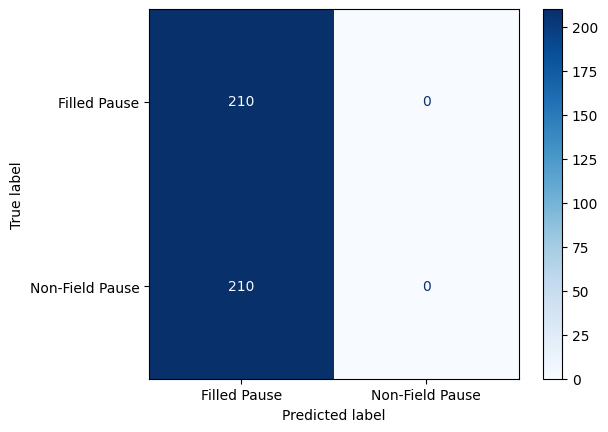

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report and confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Filled Pause", "Non-Field Pause"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Filled Pause", "Non-Field Pause"])
disp.plot(cmap="Blues")

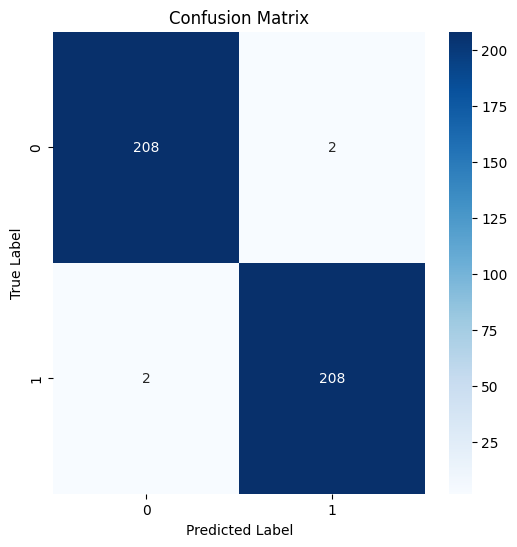

Custom Confusion Matrix:
[[208   2]
 [  2 208]]


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom confusion matrix based on the classification report
cm_custom = np.array([[208, 2],
                      [2, 208]])

# Plotting the custom confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_custom, annot=True, fmt='g', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save the confusion matrix plot as a PNG file
plt.savefig("./results/confusion_matrix.png", format='png')

# Show the plot
plt.show()

# Printing the custom confusion matrix
print("Custom Confusion Matrix:")
print(cm_custom)

In [72]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# SHAP Explainer
explainer = shap.Explainer(model, X_val)
shap_values = explainer(X_test)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 601!

In [71]:
shap.summary_plot(shap_values, X_test)

NameError: name 'shap_values' is not defined